In [2]:
import datetime
import itertools
import math
import operator
import os
import pathlib
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

import dask
import fsspec
import numpy as np
import pandas as pd
import pooch
import pystac
import rasterio
import rioxarray
import shapely
import xarray as xr
from azure.storage.blob import BlobServiceClient
from dask.distributed import Client
from dotenv import load_dotenv
from gcsfs import GCSFileSystem
from pystac import StacIO
from pystac.extensions import eo, raster
from pystac.layout import BestPracticesLayoutStrategy
from pystac.utils import JoinType, join_path_or_url, safe_urlparse
from stactools.core.utils import antimeridian
from tqdm import tqdm


In [3]:
# uncomment these lines if you do not have coclicodata in development mode installed
# dev_dir = pathlib.Path.home() / "dev"  # set the path to the location where you would like to clone the package
# dev_dir.mkdir(parents=True, exist_ok=True)

# # Clone the repository
# os.system(f"git clone https://github.com/openearth/coclicodata.git {dev_dir / 'coclicodata'}")

# # Install the package in development mode
# os.system(f"pip install -e {dev_dir / 'coclicodata'}")

from coclicodata.coclico_stac.extension import CoclicoExtension
from coclicodata.coclico_stac.io import CoCliCoStacIO
from coclicodata.coclico_stac.layouts import CoCliCoCOGLayout
from coclicodata.drive_config import p_drive

In [4]:
data_path = pathlib.Path(r"C:\Users\guarneri\OneDrive - Stichting Deltares\Documents\PostdocVault\Postdoc\ORELSE\Database\DIS 2.1 - Winbaarheidsgrids")

In [24]:
OUT_DIR = pathlib.Path.home() / "data" / "tmp" / "27_zw_test"
STAC_DIR = pathlib.Path.cwd().parent / "current"

if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    


In [25]:
pathlib.Path.home()

WindowsPath('C:/Users/guarneri')

In [26]:
file_location = pathlib.Path(r"C:\Users\guarneri\OneDrive - Stichting Deltares\Documents\PostdocVault\Postdoc\ORELSE\Database\DIS 2.1 - Winbaarheidsgrids\Combi\scenario2\metgeo\stoor0_5m")

file_name = 'win_zand_12.asc'
raster_ = rioxarray.open_rasterio(file_location / file_name)

In [27]:
raster_

<xarray.DataArray (band: 1, y: 1035, x: 893)>
[924255 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 5.026e+05 5.029e+05 ... 7.254e+05 7.256e+05
  * y            (y) float64 5.963e+06 5.963e+06 ... 5.705e+06 5.705e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

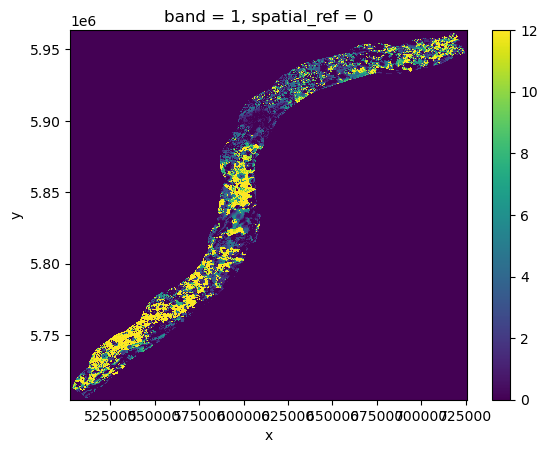

In [28]:
raster_.plot()

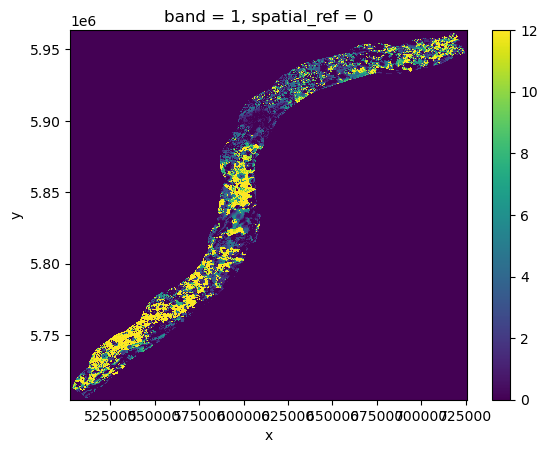

In [29]:
raster_.squeeze().plot()

In [31]:
raster_.squeeze().rio.to_raster(r'C:\Users\guarneri\OneDrive - Stichting Deltares\Documents\PostdocVault\Postdoc\ORELSE\Database\DIS2_1_Winbaarheidsgrids_COGs\Combi\scenario2\metgeo\stoor2m\wind_zand_02.cog', driver="COG")

In [ ]:
def create_collection(
    description: str | None = None, extra_fields: dict[str, Any] | None = None
) -> pystac.Collection:
    providers = [
        pystac.Provider(
            name="Deltares",
            roles=[
                pystac.provider.ProviderRole.PROCESSOR,
                pystac.provider.ProviderRole.HOST,
            ],
            url="https://deltares.nl",
        ),
        pystac.Provider(
            "Global Climate Forum",
            roles=[
                pystac.provider.ProviderRole.PRODUCER,
            ],
            url="https://globalclimateforum.org",
        ),
    ]

    start_datetime = datetime.datetime(2022, 2, 22, tzinfo=datetime.timezone.utc)

    extent = pystac.Extent(
        pystac.SpatialExtent([[-180.0, 90.0, 180.0, -90.0]]),
        pystac.TemporalExtent([[start_datetime, None]]),
    )

    links = [
        pystac.Link(
            rel=pystac.RelType.LICENSE,
            target="https://coclicoservices.eu/legal/",
            media_type="text/html",
            title="ODbL-1.0 License",
        )
    ]

    keywords = [
        "Coast",
        "Coastal Mask",
        "Coastal Change",
        "Coastal Hazards",
        "Flood Risk",
        "ORELSE",
        "Deltares",
        "Cloud Optimized GeoTIFF",
    ]

    if description is None:
        description = (
            "Coastal mask that is derived from Copernicus elevation data combined with a maximum distance"
            "to coastal water bodies."
        )

    collection = pystac.Collection(
        id="coastal-mask",
        title="Coastal Mask",
        description=description,  # noqa: E502
        license="ODbL-1.0",
        providers=providers,
        extent=extent,
        catalog_type=pystac.CatalogType.RELATIVE_PUBLISHED,
    )

    collection.add_asset(
        "thumbnail",
        pystac.Asset(
            "https://coclico.blob.core.windows.net/assets/thumbnails/coastal-mask-thumbnail.png",  # noqa: E501
            title="Thumbnail",
            media_type=pystac.MediaType.PNG,
        ),
    )
    collection.links = links
    collection.keywords = keywords

    pystac.extensions.item_assets.ItemAssetsExtension.add_to(collection)

    ASSET_EXTRA_FIELDS = {
        "xarray:storage_options": {"token": "google_default"},
    }

    collection.extra_fields["item_assets"] = {
        "data": {
            "type": pystac.MediaType.COG,
            "title": "Coastal Mask",
            "roles": ["data"],
            "description": "Coastal areas masked for this region.",
            **ASSET_EXTRA_FIELDS,
        }
    }

    if extra_fields:
        collection.extra_fields.update(extra_fields)

    pystac.extensions.scientific.ScientificExtension.add_to(collection)
    collection.extra_fields["sci:citation"] = "Lincke et al., 2023, in progress"

    # add coclico frontend properties to collection
    coclico_ext = CoclicoExtension.ext(collection, add_if_missing=True)
    coclico_ext.units = "bool"
    coclico_ext.plot_type = "raster"
    coclico_ext.min = 0
    coclico_ext.max = 1

    return collection

In [ ]:
def create_collection(
    description: str | None = None, extra_fields: dict[str, Any] | None = None
) -> pystac.Collection:
    providers = [
        pystac.Provider(
            name="Deltares",
            roles=[pystac.provider.ProviderRole.PROCESSOR, pystac.provider.ProviderRole.HOST],
            url="https://deltares.nl",
        ),
        # Assuming another relevant organization from DIS 2.1
        pystac.Provider(
            name="Rijkswaterstaat",
            roles=[pystac.provider.ProviderRole.PRODUCER],
            url="https://www.rijkswaterstaat.nl/",
        ),
        pystac.Provider(
            name="TNO Geologische Dienst Nederland",
            roles=[pystac.provider.ProviderRole.PRODUCER, pystac.provider.ProviderRole.HOST],
            url="https://www.dinoloket.nl/",
        ),
    ]

    # Adjusting the start date to reflect the DIS 2.1 project's timeline
    start_datetime = datetime.datetime(2018, 12, 11, tzinfo=datetime.timezone.utc)

    # Specifying a more accurate extent might require details from the DIS 2.1 report
    extent = pystac.Extent(
        pystac.SpatialExtent([[4.9041, 52.3676, 5.3728, 52.5197]]),  # Example coordinates
        pystac.TemporalExtent([[start_datetime, None]]),
    )
    links = [
        pystac.Link(
            rel=pystac.RelType.LICENSE,
            target="https://orelse.nl/legal/",
            media_type="text/html",
            title="ODbL-1.0 License", # Adjust based on the actual license
        )
    ]


    # Updating keywords to reflect the report's focus areas
    keywords = [
        'Noordzeezand / North Sea Sand',
        'Submarine Zandafzettingen / Submarine Sand Deposits',
        'Zandkwaliteitsnormen / Sand Quality Standards',
        'Winning van Marien Zand / Marine Sand Extraction',
        'Preventie van Kusterosie / Coastal Erosion Prevention',
        'DIS 2.1 Dataset',
        'Mariene Geologie / Marine Geology',
        'Zandvoorraden / Sand Reserves',
        'Kustbescherming / Coastal Protection',
        'Duurzame Zandwinning / Sustainable Sand Extraction"Sand Extraction'
        'Sand Thikness',
        'Dutch North Sea',
        'Sand Layers',
        'Volume Calculations',
    ]

    if description is None:
        description = 'The "Update Delfstoffen Informatie Systeem DIS 2.1" datasets offers a detailed analysis of North Sea sand deposits, focusing on their locations, qualities, and volumes suitable for extraction. It's essential for coastal defense, sustainable extraction, and marine geology, providing valuable insights for environmental management, construction, and policymaking sectors.'

    # Assuming a relevant asset for DIS 2.1
    thumbnail_url = "https://cms.deltares.nl/assets/common/_medium/winbaar-zand.png"

    collection = pystac.Collection(
        id="DIS-2-1",
        title="Update Delfstoffen Informatie Systeem DIS 2.1",
        description=description,
        license="Custom License",  # Adjust based on the actual license
        providers=providers,
        extent=extent,
        catalog_type=pystac.CatalogType.RELATIVE_PUBLISHED,
    )

    collection.add_asset(
        "thumbnail",
        pystac.Asset(
            thumbnail_url,
            title="Thumbnail",
            media_type=pystac.MediaType.PNG,
        ),
    )
    
    collection.links = links
    collection.keywords = keywords

    # Additional modifications as necessary based on the report details
    return collection


In [5]:
import json
import pystac
from datetime import datetime

# Load the directory tree from the JSON file
path_ = Path(r"C:\Users\guarneri\OneDrive - Stichting Deltares\Documents\PostdocVault\Postdoc\ORELSE\Database\DIS2_1_Winbaarheidsgrids_COGs\Combi")
with open(path_ / 'directory_tree.json', 'r') as file:
    directory_tree = json.load(file)

def create_collection_from_directory(directory):
    """
    Creates a STAC Collection from a given directory dictionary.
    """
    collection_id = directory['name']
    description = f"Collection for {collection_id}"
    # Define a generic spatial extent that you might want to replace with actual extents
    spatial_extent = pystac.SpatialExtent([[-180.0, -90.0, 180.0, 90.0]])
    # Define a generic temporal extent
    temporal_extent = pystac.TemporalExtent([[datetime.utcnow(), None]])
    extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)
    
    collection = pystac.Collection(id=collection_id, description=description, extent=extent)
    
    for file_info in directory['files']:
        item_id = file_info['name'].split('.')[0]
        item = pystac.Item(id=item_id,
                           geometry=None,  # Define geometry or set to None
                           bbox=None,  # Define bbox or set to None
                           datetime=datetime.utcnow(),
                           properties={})
        
        # Add more details to the item or assets here
        item.add_asset("data", pystac.Asset(href=file_info['path'], media_type=pystac.MediaType.GEOTIFF))
        
        collection.add_item(item)
    
    return collection

# Example: Create a collection for the first scenario
first_scenario_directory = next(filter(lambda d: d['name'] == 'scenario1', directory_tree['directories']), None)
if first_scenario_directory:
    for subdirectory in first_scenario_directory['directories']:
        collection = create_collection_from_directory(subdirectory)
        print(collection.to_dict())

{'type': 'Collection', 'id': 'metgeo', 'stac_version': '1.0.0', 'description': 'Collection for metgeo', 'links': [], 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]}, 'temporal': {'interval': [['2024-03-19T17:13:03.424148Z', None]]}}, 'license': 'proprietary'}
{'type': 'Collection', 'id': 'zondergeo', 'stac_version': '1.0.0', 'description': 'Collection for zondergeo', 'links': [], 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]}, 'temporal': {'interval': [['2024-03-19T17:13:03.424148Z', None]]}}, 'license': 'proprietary'}


In [6]:
import json
import pystac

# Assuming this is a function you have that converts ASC files to COG
def convert_asc_to_cog(asc_file_path):
    
    cog_file_path = asc_file_path.replace('.asc', '.tif') # Placeholder conversion logic
    if not os.path.exists(cog_file_path):
        # Placeholder conversion logic
        asc_file = rioxarray.open_rasterio(root_data / Path(asc_file_path))
        asc_file.squeeze().rio.to_raster(cog_file_path, driver="COG")
        # Log the successful conversion based on cog_file existence cathing the exception        
        if os.path.exists(cog_file_path):
            print(f"Converted {asc_file_path} to {cog_file_path}")
        else:
            print(f"Failed to convert {asc_file_path} to COG")

    return cog_file_path

def process_directory(directory, parent_collection=None):
    collection_id = directory['name']
    if collection_id:  # Skip the root directory which might not have a name
        collection = pystac.Collection(
            id=collection_id,
            description=f"Collection for {collection_id}",
            extent=pystac.Extent(
                spatial=pystac.SpatialExtent([[-180.0, -90.0, 180.0, 90.0]]),
                temporal=pystac.TemporalExtent([[None, None]])
            )
        )
        if parent_collection:
            parent_collection.add_child(collection)
        else:
            parent_collection = collection  # For the root collection

    for file in directory.get('files', []):
        if file['name'].endswith('.asc'):
            cog_path = convert_asc_to_cog(file['path'])  # Convert ASC to COG
            item_id = file['name'].replace('.asc', '')
            item = pystac.Item(
                id=item_id,
                geometry=None,  # Define actual geometry here
                bbox=None,  # Define actual bbox here
                datetime=datetime.date("2020/02/02"),  # Define actual datetime here, if applicable
                properties={}
            )
            item.add_asset("data", pystac.Asset(href=cog_path, media_type=pystac.MediaType.COG))
            parent_collection.add_item(item)

    for subdir in directory.get('directories', []):
        process_directory(subdir, parent_collection)

# Load directory structure from the JSON file
with open(path_ / 'directory_tree.json', 'r') as f:
    directory_tree = json.load(f)

root_collection = pystac.Collection(
    id="root",
    description="Root Collection containing all scenarios",
    extent=pystac.Extent(
        spatial=pystac.SpatialExtent([[-180.0, -90.0, 180.0, 90.0]]),
        temporal=pystac.TemporalExtent([[None, None]])
    )
)

root_data = Path(r'C:\Users\guarneri\OneDrive - Stichting Deltares\Documents\PostdocVault\Postdoc\ORELSE\Database\DIS2_1_Winbaarheidsgrids_COGs\Combi')

process_directory(directory_tree, root_collection)

# Here you can save your root_collection to a STAC Catalog as needed


CPLE_OpenFailedError: Attempt to create new tiff file './scenario1\metgeo\stoor0_5m\stoorlaag_0_5m.tif.ovr.tmp' failed in VSI_TIFFOpen().

In [45]:
path_ / 'directory_tree.json'

WindowsPath('C:/Users/guarneri/OneDrive - Stichting Deltares/Documents/PostdocVault/Postdoc/ORELSE/Database/DIS2_1_Winbaarheidsgrids_COGs/Combi/directory_tree.json')

In [7]:
asc_file_path = path_ / 'scenario1' / 'metgeo' / 'stoor0_5m' / 'stoorlaag_0_5m.asc'
cog_file_path = asc_file_path.with_suffix('.tif')
if not os.path.exists(cog_file_path):
    # Placeholder conversion logic
    asc_file = rioxarray.open_rasterio(root_data / Path(asc_file_path))
    asc_file.squeeze().rio.to_raster(cog_file_path, driver="COG")
    # Log the successful conversion based on cog_file existence cathing the exception        
    if os.path.exists(cog_file_path):
        print(f"Converted {asc_file_path} to {cog_file_path}")
    else:
        print(f"Failed to convert {asc_file_path} to COG")

Converted C:\Users\guarneri\OneDrive - Stichting Deltares\Documents\PostdocVault\Postdoc\ORELSE\Database\DIS2_1_Winbaarheidsgrids_COGs\Combi\scenario1\metgeo\stoor0_5m\stoorlaag_0_5m.asc to C:\Users\guarneri\OneDrive - Stichting Deltares\Documents\PostdocVault\Postdoc\ORELSE\Database\DIS2_1_Winbaarheidsgrids_COGs\Combi\scenario1\metgeo\stoor0_5m\stoorlaag_0_5m.tif


In [58]:
help Path.replace

SyntaxError: invalid syntax (345450240.py, line 1)

In [59]:
#replace file extension of Path
asc_file_path = path_ / 'Combi' / 'scenario1' / 'metgeo' / 'stoor0_5m' / 'win_zand_12.asc'
cog_file_path = asc_file_path.with_suffix('.tif') # Placeholder conversion logic